In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 4: Language Modeling, Recurrent Neural Networks, & Transformers


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, & Chris Gumb


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [4]:
%pip install sentencepiece==0.2.0
try:
    import sentencepiece
except ImportError:
    print("Installing sentence...")
    !pip install -q --no-warn-script-location sentence-piece==0.2.0
    print("Done!\n⚠️ Please restart kernel for changes to take effect (Kernel > Restart)")
print("sentencepiece version:", sentencepiece.__version__)

   ---------------------------------------- 0.0/992.0 kB ? eta -:--:--
   --------------------------------------- 992.0/992.0 kB 11.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
sentencepiece version: 0.2.0


In [6]:
import os
import pickle
import re
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

%pip install -q --no-warn-script-location transformers==4.28.1
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDebertaV2ForSequenceClassification
from transformers import TFBertPreTrainedModel, TFBertMainLayer, BertConfig

os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [62 lines of output]
      C:\Users\khcod\AppData\Local\Temp\pip-build-env-qqo7dhmi\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: Apache Software License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        self._finalize_license_expression()
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd

ModuleNotFoundError: No module named 'transformers'


<a id="contents"></a>

## Notebook Contents

- [**PART 1: RNN: Language Model for Text Generation**](#part1)

- [**PART 2: RNN: Named Entity Recognition**](#part2)

- [**PART 3: Transformers: Text Classification**](#part3)

## About this Homework

In this homework, we will explore recurrent neural networks (RNNs) and transformers (more specifically, the encoder half of the transformer architecture).

- In [PART 1](#part1), we will use a recurrent neural network to generate our own nonsense poems in the style of Edward Lear.


- Then, in [PART 2](#part2), we will will use a recurrent network for the multiclass classification NLP task of named entity recognition, and investigate the embeddings learned by the network.

- Finally, in [PART 3](#part3), we will tune a pre-trained BERT model for text classification.  

**IMPORTANT NOTES:**

- The neural networks in this assignment are computationally intensive.
- **We highly recommend that you train your model on the [GPU-enabled Jupyter environment](https://ood.huit.harvard.edu/pun/sys/dashboard/batch_connect/sys/ood-jupyterlab-spack-conda/cs1090b/session_contexts/new) provided to you as part of this course.** 
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- **To avoid getting frustrated by having to re-train your models every time you run your notebook, you should save your trained model weights for later use.** Model history dictionaries can also be saved to disk with `pickle` and checked with an `if not` condition. This is a great way to check if the model weights exist before training, preventing redundant retraining. Please, think of the penguins! 🐧

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many images in GPU memory. Avoid using a very large batch size or attempting to `cache` large datasets.
- Avoid creating multiple copies of the data.

In [7]:
# measure notebook runtime
time_start = time.time()

<a id="part1"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


### **PART 1: Character Level Text Generation**
    
Building a language model is a common task in natural language processing, and it involves training a machine learning algorithm to predict the probability of the next token in a sequence given the previous token(s). In the case of text generation, this model can be used to generate new text that is similar in style and tone to the original text used to train the model.
 
In the first part of this assignment, you'll be building a character level language model to generate text in the style of [Edward Lear](https://en.wikipedia.org/wiki/Edward_Lear) (1812-1888), a famous English writer and artist known for his humorous poetry and prose. 

<center>
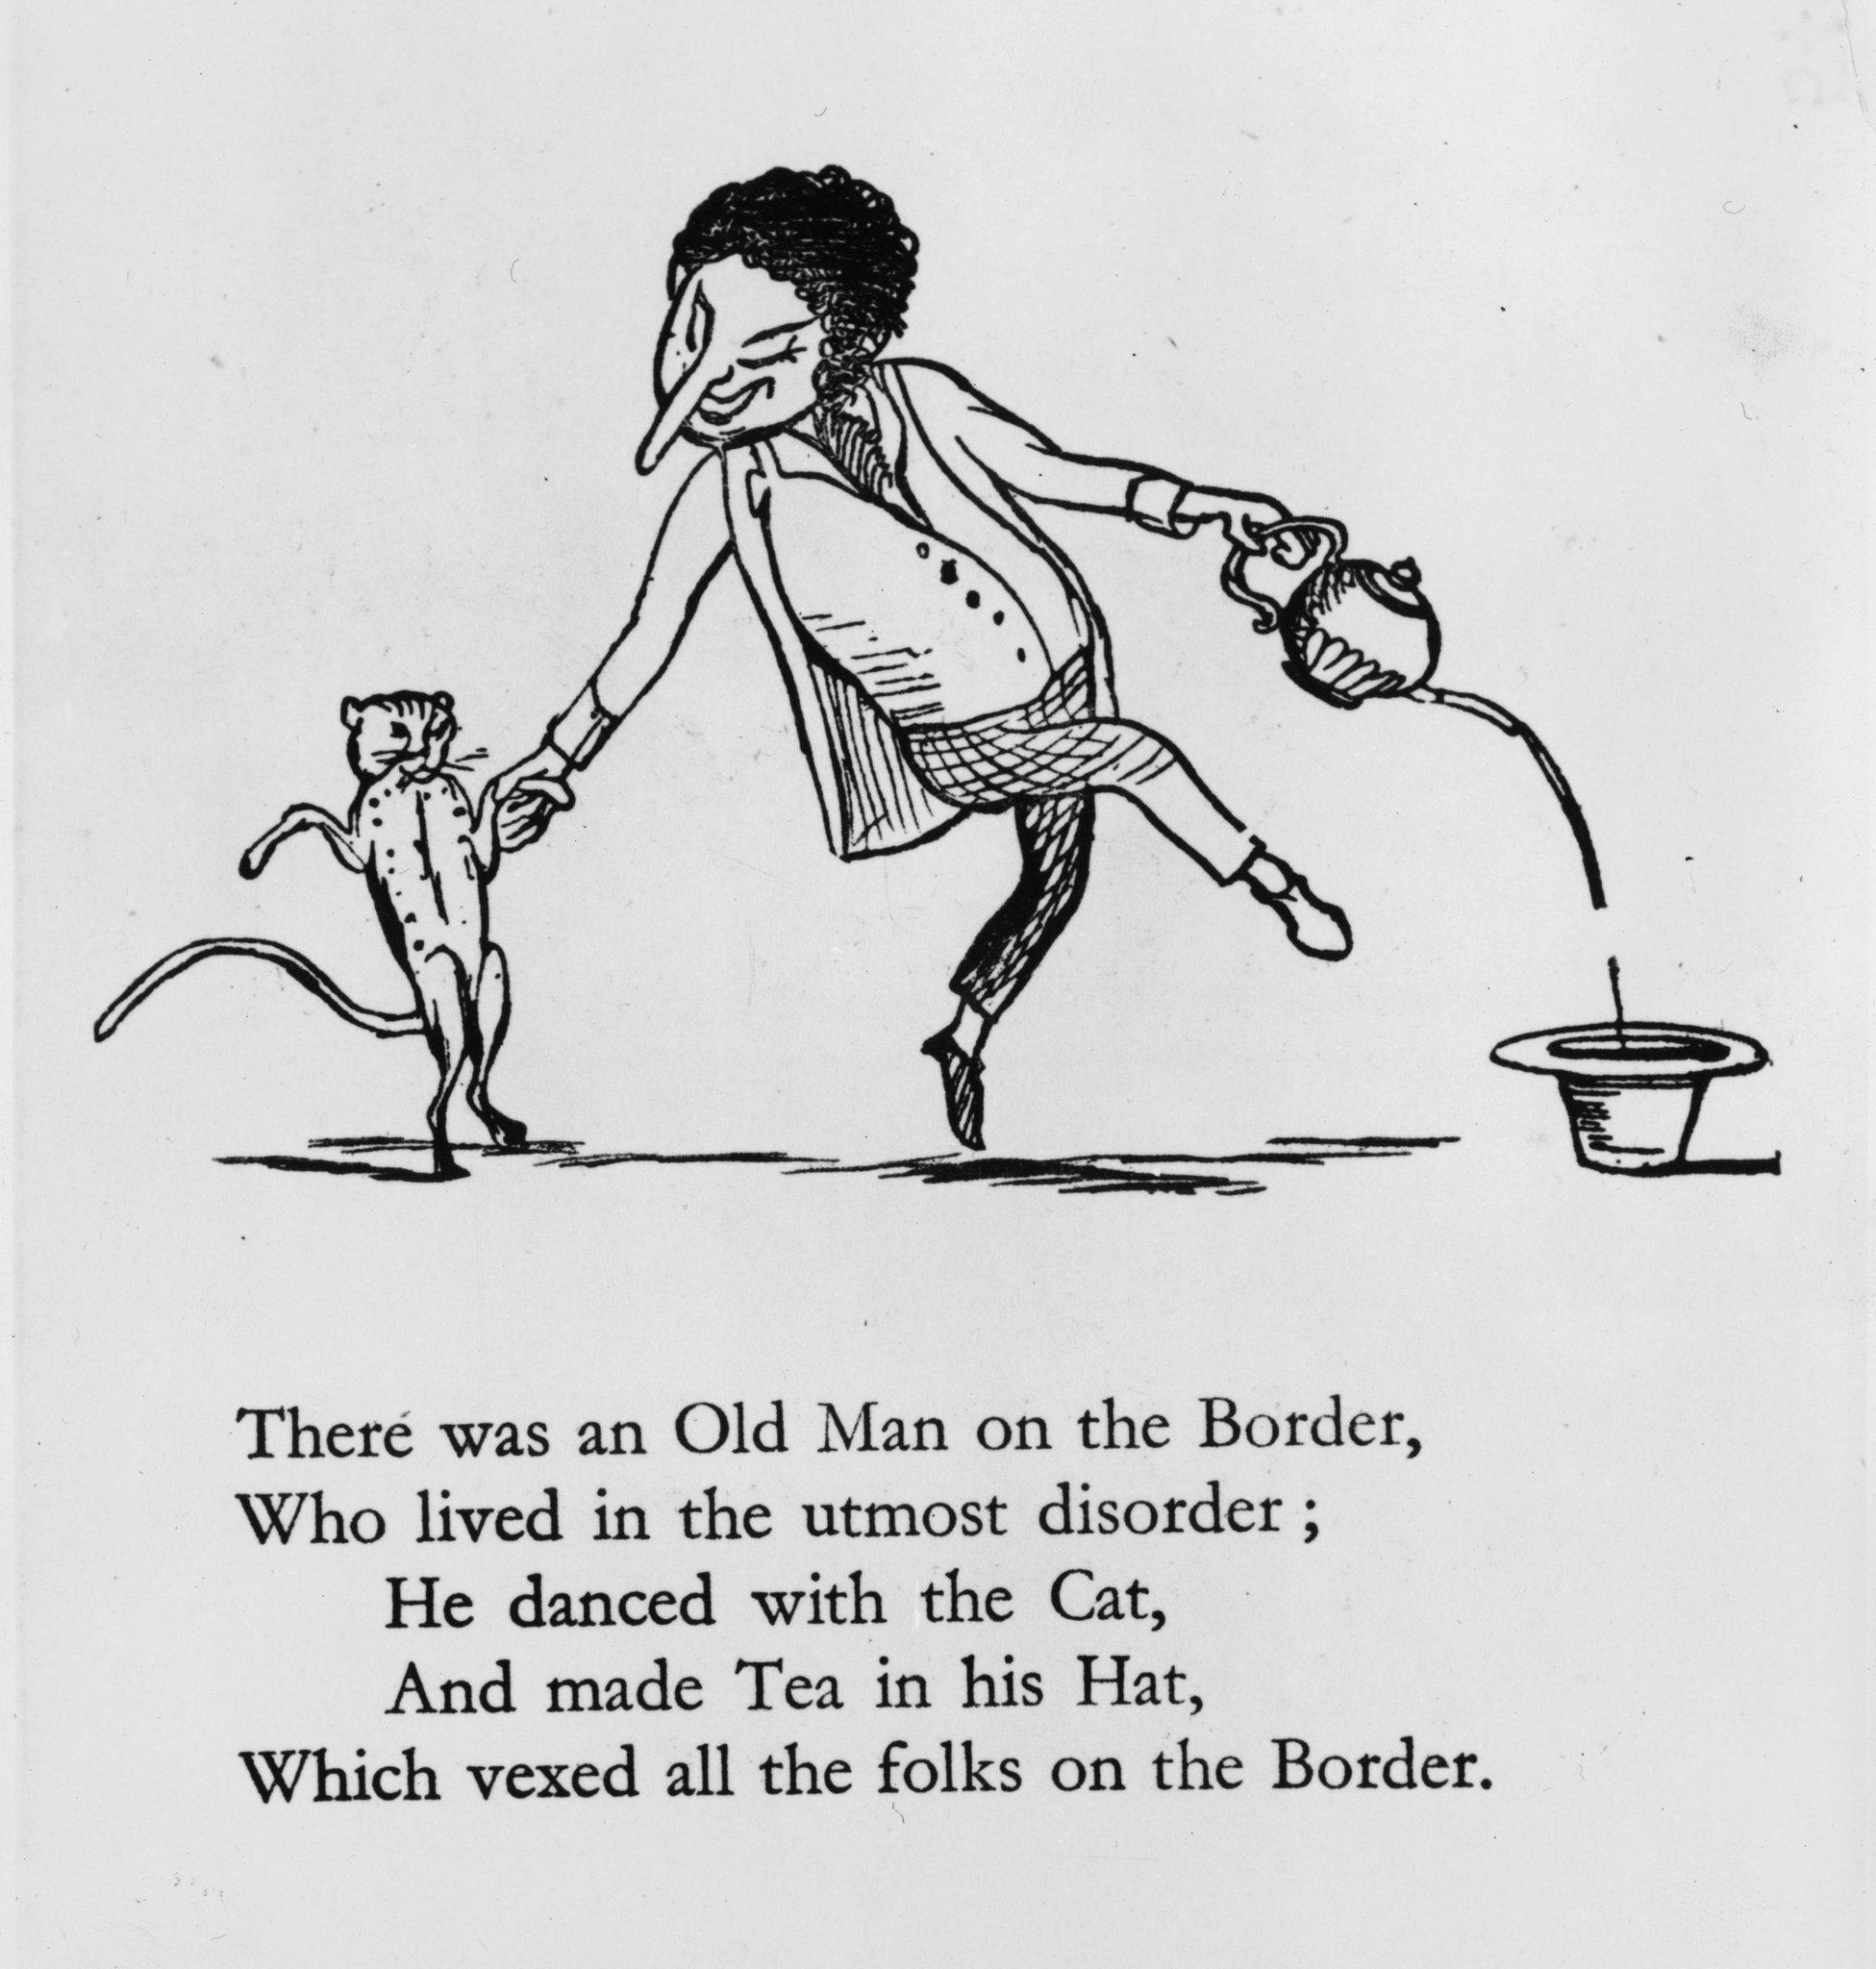

</center>
    
Lear's writing is particularly well-suited to text generation because of its playful and nonsensical nature. Lear often made use of invented words, portmanteaus, and other forms of wordplay, and his writing style is characterized by a sense of whimsy and playfulness that lends itself well to creative exploration.

Ready to get started? Let's dive in!
    
</div>

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.1 - Reading & Cleaning the Text**
    
Read the contents of the file `data/edward_lear.txt` and store it in a variable called `text_raw`. The text contained in this file is an excerpt of content made available thanks to [Project Gutenberg](https://www.gutenberg.org/) and is distributed under their licence. Project Gutenberg is a great place to find texts for NLP projects.
    
    
*(The full text they distribute, data/pg13650.txt, is included in our files to adhere to their licence.)*
    
<br>    
    
Next, implement a function `text_clean` that converts a string to lowercase and replace any number of contiguous whitespace characters with a single space (e.g., `'\n\n'` -> `' '`). Use it on `text_raw` and save the result as `text`. This will make our langauge modeling task a bit simpler and the output of our text generation easier to read.
</div>

In [8]:
# Read the contents of the file `data/edward_lear.txt` and store it in a variable called `text_raw`
with open("data/edward_lear.txt", "r") as f:
    text_raw = f.read()
text_raw

'A BOOK OF NONSENSE\n\nby\n\nEDWARD LEAR.\n\nWith All the Original Pictures and Verses\n\n\n\n\n\n\n\n[Illustration]\n\n\nThere was an Old Derry down Derry, who loved to see little folks\n  merry;\n    So he made them a Book, and with laughter they shook\n      At the fun of that Derry down Derry.\n\n\n\n                 Original Dedication.\n\n                       TO THE\n GREAT-GRANDCHILDREN, GRAND-NEPHEWS, AND GRAND-NIECES\n           OF EDWARD, 13TH EARL OF DERBY,\n          THIS BOOK OF DRAWINGS AND VERSES\n\n     (The greater part of which were originally\n         made and composed for their parents.)\n\n               Is Dedicated by the Author,\n                                          EDWARD LEAR.\n\n       London, 1862.\n\n\n       *        *        *        *        *\n\n\n\n\n    [Illustration]\n\n    There was an Old Man with a nose,\n    Who said, "If you choose to suppose\n    That my nose is too long, you are certainly wrong!"\n    That remarkable Man with a nose.\n

In [9]:
# implement a function `text_clean` that converts a string to lowercase and replace any number of contiguous whitespace characters with a single space (e.g., `'\n\n'` -> `' '`)
import re
def text_clean(text):
    """
    Clean the input text by converting to lowercase and replacing multiple whitespace characters with a single space.
    
    Args:
        text (str): The input text to clean.
        
    Returns:
        str: The cleaned text.
    """
    text = text.lower()
    
    # replace all multiple whitespace characters with one space
    text = re.sub(r'\s+', ' ', text)
    
    return text

text = text_clean(text_raw)
text[:1000] 

'a book of nonsense by edward lear. with all the original pictures and verses [illustration] there was an old derry down derry, who loved to see little folks merry; so he made them a book, and with laughter they shook at the fun of that derry down derry. original dedication. to the great-grandchildren, grand-nephews, and grand-nieces of edward, 13th earl of derby, this book of drawings and verses (the greater part of which were originally made and composed for their parents.) is dedicated by the author, edward lear. london, 1862. * * * * * [illustration] there was an old man with a nose, who said, "if you choose to suppose that my nose is too long, you are certainly wrong!" that remarkable man with a nose. [illustration] there was a young person of smyrna, whose grandmother threatened to burn her; but she seized on the cat, and said, "granny, burn that! you incongruous old woman of smyrna!" [illustration] there was an old man on a hill, who seldom, if ever, stood still; he ran up and d

In [10]:
# Display length of cleaned corpus
print(f"Corpus length: {len(text):,}")

Corpus length: 133,762


In [11]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.2 - Character-Integer Mappings**

We will be building a character-level language model. Instead of treating words as tokens, we will treat each individual character as a token. This approach allows for more granular modeling of text, but it comes at the expense of increased computational complexity.

To make this possible, we need to create two-way character to integer mappings. We will assign each unique character in our text a unique integer identifier, and we will use this integer identifier to represent the character in our neural network. 

Your task is to create a sorted list called `chars` of all the unique characters in the processed `text` variable. Then, create two dictionaries: `char2idx` and `idx2char`. `char2idx` should map each unique character to its unique integer identifier, which is the index at which that character appears in `chars`. Conversely, `idx2char` should map each integer identifier to its corresponding unique character. These mappings will be essential for feeding our text data into the neural network, which requires numeric data.
</div>


In [12]:
# sorted unique char list
chars = sorted(set(text))

# char<>index mappings
char2idx = {u:i for i, u in enumerate(chars)}
idx2char = {v:k for k, v in char2idx.items()}
print(f"Character mappings: {char2idx}")

Character mappings: {' ': 0, '!': 1, '"': 2, '&': 3, "'": 4, '(': 5, ')': 6, '*': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, ':': 21, ';': 22, '?': 23, '[': 24, ']': 25, '_': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52, 'è': 53, 'ò': 54, 'ô': 55, 'ö': 56}


In [13]:
# Display number of unique chars
print("Total chars:", len(chars))

Total chars: 57


In [14]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.3 - Input Sequence and Target Pairs**

Now that we have our character to integer mappings, we can begin creating our input sequence and target pairs. This process involves breaking up our text into fixed-length sequences, where each sequence is used to predict the character that follows that sequence in the text. 

Your task is to implement the code to generate these input sequence and target pairs using the following hyperparameters:
- `SEQ_LEN`: the length of each input sequence (default 100)
- `STEP`: the stride between each sequence (default 1)
    
For example, suppose our input text is "the owl and the pussy-cat went to sea". If `SEQ_LEN` is 5 and `STEP` is 2, we will create the following input sequences and target pairs:

| input sequence | target pair |
|---|---|
| `['t', 'h', 'e', ' ', 'o']` | `'w'` |
| `['e', ' ', 'o', 'w', 'l']` | `' '` |
| `['o', 'w', 'l', ' ', 'a']` | `'n'` |
| `['l', ' ', 'a', 'n', 'd']` | `' '` |
| `['a', 'n', 'd', ' ', 't']` | `'h'` |
| `['d', ' ', 't', 'h', 'e']` | `' '` |
| `['t', 'h', 'e', ' ', 'p']` | `'u'` |
| `['e', ' ', 'p', 'u', 's']` | `'s'` |
| `['p', 'u', 's', 's', 'y']` | `'-'` |
| `['s', 's', 'y', '-', 'c']` | `'a'` |
| `['y', '-', 'c', 'a', 't']` | `' '` |
| `['c', 'a', 't', ' ', 'w']` | `'e'` |
| `['t', ' ', 'w', 'e', 'n']` | `'t'` |
| `['w', 'e', 'n', 't', ' ']` | `'t'` |
| `['n', 't', ' ', 't', 'o']` | `' '` |
| `[' ', 't', 'o', ' ', 's']` | `'e'` |

You will need to create two numpy arrays: `x` and `y`. `x` should be an integer numpy array of shape (num_sequences, `SEQ_LEN`), where num_sequences is the total number of input sequences. Each element of `x` should be an integer representing the character at that position in the input sequence. `y` should be an integer numpy array of shape (num_sequences,), where each element is the integer representation of the target character for the corresponding input sequence.

After you have generated `x` and `y`, print their shapes and data types.
</div>

In [15]:
# create two numpy arrays: `x` and `y`. `x` should be an integer numpy array of shape (num_sequences, `SEQ_LEN`)
# and `y` should be an integer numpy array of shape (num_sequences,) where each element is the integer representation of the target character for the corresponding input sequence
x = []
y = []
SEQ_LEN = 100
for i in range(len(text) - SEQ_LEN):
    x.append([char2idx[c] for c in text[i:i+SEQ_LEN]])
    y.append(char2idx[text[i+SEQ_LEN]])

x = np.array(x)
y = np.array(y)

In [16]:
# Display info of input sequences and targets
print("Number of sequences:", len(x))
print("x shape:", x.shape)
print("y shape:", y.shape)

Number of sequences: 133662
x shape: (133662, 100)
y shape: (133662,)


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.4 - Creating a TensorFlow Dataset Pipeline**

Now that we have prepared our input-output data, we need to create a TensorFlow dataset pipeline to feed it into our recurrent neural network. TensorFlow datasets provide an efficient and flexible way to handle large amounts of data and are particularly useful when working with deep learning models.

To create a TensorFlow dataset pipeline from our input-output data, we will use the `tf.data.Dataset.from_tensor_slices` method. This method takes a tuple of arrays or tensors and returns a dataset of slices along the first dimension. 

To optimize our training process, we will also shuffle our data, batch it into smaller chunks, and prefetch it to keep the GPU busy while the CPU is preparing the next batch. These operations should be performed in the following order: shuffle, batch, prefetch. Save this pipeline as `dataset`.

</div>


In [ ]:
# use the `tf.data.Dataset.from_tensor_slices` method to create a dataset from the `x` and `y` arrays. 
dataset = tf.data.Dataset.from_tensor_slices((x, y))

# shuffle our data, batch it into smaller chunks of size 64, and drop the last batch if it is smaller than 64
dataset = dataset.shuffle(buffer_size=10000).batch(64, drop_remainder=True)

# prefetch 
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
# check the dataset
for x, y in dataset.take(2):
    print("x shape:", x.shape)
    print("y shape:", y.shape)

x shape: (64, 100)
y shape: (64,)
x shape: (64, 100)
y shape: (64,)


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.5 - Recurrent Neural Network**

Now it's time to build and compile our recurrent neural network! 

Your task is to construct a model with the Keras API that has the following architecture:

- The model should include at least one type of recurrent unit (check imports for some options).
- The output layer should have a `softmax` activation function, and output a probability distribution over each of the possible characters.
- Compile the model with an appropriate optimizer and loss function for the task.
- Display a summary of the model's architecture.

Make sure to consider the dimensions of `x` and `y` when constructing the model, and pay close attention to the input and output shape of the layers.
    
**Hints:**
- Your input sequences are currenlty sequences of intergers which are far from ideal and will likely lead to very poor performance. You could one-hot encode each character in the sequence as a sparse vector, but that (1) takes up more memory and (2) means all characters are orthogonal to one another. The best option would be to explore [Keras's Embedding layer](https://keras.io/api/layers/core_layers/embedding/) which will convert your integer input sequences into sequences of learnable, non-sparse vectors, allowing the model to represent some characters as similar to one another.
- Your targets are integers. You could one hot encode them to use categorical cross entropy as a loss, but this also takes up more memory. Better to explore what your [other loss options](https://keras.io/api/losses/) are for a scenario like this.
- Please feel free to experiement in your search for an optimal architecture and set of hyperparameters, but its bets to start of simple. In the final question of part 1 you will discuss the various approaches you tried.
</div>

In [20]:
# use [Keras's Embedding layer] convert your target integer input sequences into sequences of learnable, non-sparse vectors
import keras.backend as K
from keras.initializers import RandomNormal
from keras.layers import Embedding

# set the embedding dimension to 256
EMBEDDING_DIM = 256

#convert one-hot-encodings to vectors
embedding_matrix = RandomNormal(mean=0.0, stddev=0.05, seed=None)(shape=(len(chars), EMBEDDING_DIM))
embedding_layer = Embedding(input_dim=len(chars), output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)
embedding_layer

# build recurrent neural network Keras model
# GRU recurrent unit, softmax` activation function for output probabilities of different characters
model = Sequential()
model.add(Input(shape=(SEQ_LEN,)))
model.add(embedding_layer)
model.add(GRU(256, return_sequences=True))
model.add(GRU(256))
model.add(Dense(len(chars), activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 256)       │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 57)             │        14,649 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,745 (3.12 MB)

 Trainable params: 818,745 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.6 - Temperature**
    
When generating text with a language model, we want to balance between predictability and randomness. We use the notion of temperature to control the amount of randomness in the text. Here's how it works:

Given a probability distribution of the next character, the temperature is applied as a scaling factor to the log probabilities. This is done to adjust the shape of the distribution. A higher temperature means a flatter distribution, where all characters are equally likely, and a lower temperature means a sharper distribution, where the most probable character has a higher probability.

Your task is to implement a function called `sample` which takes in three arguments: `preds` - the probability distribution of the next character, `temperature` - the temperature to be applied, and `eps` - a small value to prevent us from taking the log of zero. It should return an integer corresponding to the index of the sampled character. Here's the formula for the sampling probabilities when applying temperature:

$$
\text{probas} = \frac{\exp{\big[\log{(\text{preds}_i)}\ /\ T\big]}}{\sum_j{\exp{\big[\log{(\text{preds}_j)}\ /\ T\big]}}}
$$
 
You will likely want to make use of numpy's logarithm and exponential functions as well as `np.random.multinomial` to implement `sample`.
    
</br>

**Note:** to avoid issues with numerical precission it may be necessary to convert `preds` to type np.float64.

In [21]:
def sample(preds, temperature=1.0, eps=1e-10):
    ''' which takes in three arguments: 
    `preds` - the probability distribution of the next character, 
    `temperature` - the temperature to be applied,
    `eps` - a small value to prevent us from taking the log of zero. It should return an integer corresponding to the index of the sampled character
    '''
    preds = np.log(preds + eps) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    # sample from multinomial distribution - sample from categorical
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas, axis=1)[0]

In [22]:
grader.check("q1.6")

q1.6 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.7 - Text Generation Callback**

As we train our recurrent neural network, we want to be able to monitor its progress and see how well it is doing at each epoch. Looking at the loss can tell us if the model is improving, but it doesn't give us an idea of what the generated text looks like. By generating example text during training, we can get a sense of whether the model is producing text that is coherent and in the style of the training corpus.
    
Implement a function `generate_text` to be used as part of a lambda callback at the end of each training epoch.
    
**Function arguments**
- `epoch`: integer representing the current epoch number.
- `_`: internal keras callback parameter (not used in this function).

**Output**
- Prints generated strings and their corresponding temperatures.

**Function requirements**
- For each temperature value in `[0.2, 0.5, 1.0]`, perform the following steps:
    1. Sample a random, 'seed' sequence from the training data
    2. Print the seed sequence.
    3. Generate a string with 400 characters by iteratively:
        1. Predict the next character distribution by passing the numerically encoded seed sequence using the model.
        2. Use the `sample` function with the chosen temperature to select a character from the predicted distribution.
        3. Append the selected character to the end of the seed sequence and drop the first character.
    4. Print the generated string and its corresponding temperature.

Here is an example implementation scaffold of `generate_text` that you can use as a reference:
```python
def generate_text(epoch, _):
    print()
    print("Generating text after epoch: %d" % epoch)
    
    for temperature in [0.2, 0.5, 1.0]:
        print("...Temperature:", temperature)

        # Step 1: Sample a random starting index from the training text.
        ...

        # Step 2: Retrieve the seed sequence from the training text.
        ...
        # Step 3: Print the seed sequence.
        print('...Generating with seed: "' + seed + '"')

        # Initialize an empty string to store the generated text.
        generated = ""

        # Generate 200 characters.
        for i in range(200):
            ...
```
    
</div>

In [ ]:
def generate_text(epoch, _):
    print()
    print("Generating text after epoch: %d" % epoch)
    
    for temperature in [0.2, 0.5, 1.0]:
        print("...Temperature:", temperature)

        # Step 1: Sample a random starting index from the training text.
        start_index = np.random.randint(0, len(text) - SEQ_LEN - 1)

        # Step 2: Retrieve the seed sequence from the training text.
        seed = text[start_index: start_index + SEQ_LEN]
        seed = [char2idx[c] for c in seed]
        seed = np.reshape(seed, (1, SEQ_LEN))
        seed = embedding_layer(seed)

        # Step 3: Print the seed sequence.
        print('...Generating with seed: "' + seed + '"')

        # Initialize an empty string to store the generated text.
        generated = ''

        # Generate 200 characters.
        for i in range(200):
            preds = model.predict(seed, verbose=0)[0]

            # Step 5: Sample the next character using the `sample` function.
            next_index = sample(preds, temperature=temperature)
            next_char = idx2char[next_index]

            # Step 6: Append the predicted character to the generated text.
            generated += next_char

            # Step 7: Update the seed sequence for the next iteration.
            seed = np.concatenate([seed[:, 1:], embedding_layer(np.array([[next_index]]))], axis=1)
            seed = np.reshape(seed, (1, SEQ_LEN, EMBEDDING_DIM))
        
        print(generated)

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.8 - Training the Model with Lambda Callback**

Now that you have created a dataset pipeline, constructed your RNN, and implemented a function to generate text, it's time to train your RNN model on the data!

In order to monitor the training progress, use the `generate_text` function that you implemented in the previous question as part of a `LambdaCallback` to generate some sample text at 3 different temperature at the end of each epoch.

After training for at least 5 epochs, plot the training loss across epochs.
</div>

In [24]:
# Training the RNN
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')
# Lambda callback to generate text after each epoch
generate_text_callback = LambdaCallback(on_epoch_end=generate_text)
# Model checkpoint callback to save the best model
checkpoint_path = "best_model.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='loss', mode='min')
# Train the model
history = model.fit(dataset, epochs=50, callbacks=[early_stopping, generate_text_callback, checkpoint_callback], verbose=1)

Epoch 1/50
  15/2088 ━━━━━━━━━━━━━━━━━━━━ 8:44 253ms/step - accuracy: 0.1248 - loss: 3.7792

KeyboardInterrupt: 

In [ ]:
# Plot training history
...

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.9 - Perplexity for Language Models**
    
In natural language processing, perplexity is a commonly used metric to evaluate the quality of language models. It measures how well a model predicts a sequence of words (or characters in the case of our RNN), given a sequence of words. 
    
Perplexity is a measure of how surprised a model is to see an unseen sequence of words. It is related to entropy, a concept from information theory that measures the amount of information in a probability distribution. In fact, perplexity can be interpreted as the exponentiation of the entropy of a language model.
    
The formula for perplexity is:
    
$$\text{Perplexity} = 2^{-\frac{1}{N} \sum_{i=1}^N \log_2 P(w_i | w_1^{i-1}) }$$
    
where $N$ is the number of words (or characters) in the test set, and $P(w_i | w_1^{i-1})$ is the probability of the $i$-th word given the previous $i-1$ words.
    
A lower perplexity score indicates that the model is better at predicting the next word in a sequence. A perfect model would have a perplexity of 1, indicating that it is not at all surprised to see the next word in the sequence.
    
To implement a perplexity function for your character-level RNN, you can follow these steps:
1. Pass a sequence of input characters through the model to get the predicted probability distribution for the next character.
2. Calculate the cross-entropy loss between the predicted probability distribution and the actual target character.
3. Accumulate the loss for each character in the test set.
4. Compute the average loss across all characters in the test set.
5. Compute the perplexity score by exponentiating the average loss.
    
Below is a skeleton implementation for a possible perplexity function that takes in a trained model and a dataset of test sequences. The function returns the perplexity score of the model on the provided dataset. While less than ideal, because we have only the one small corpus, we will calculate perplexity on the training data.
    
```python
def calculate_perplexity(model, dataset):
    total_loss = 0
    steps = 0 # number of chars predicted on so far
    
    for x, y in dataset:
        # Get predictions from the model
        ...
        
        # Flatten the targets and predictions to 2D arrays
        ...
        
        # Calculate the loss and add it to the running total
        ...
        
    # Calculate the average loss and perplexity
    avg_loss = ...
    perplexity = ...
    
    return perplexity
```

**Hints:**
    
- If the calculation is slow you may consider adding an optional `batch_size` argument to your function which will `unbatch` and then re-batch the dataset with a higher batch size.
- You may be able to make use of a loss from `keras.losses` as part of your calculation
- If you are encoutering nans or infs you should make sure you are using higher precision variable types (e.g., `tf.float64`) to avoid under/overflow issues.
    
</div>

In [ ]:
def calculate_perplexity(model, dataset, batch_size=64):
    ...

perplexity = ...

In [ ]:
# Display final train perplexity
print(f"Train Perplexity: {perplexity:.2f}")

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.10 - Model Assessment**
    
Now, it's time to see what kind of wacky and wonderful text your model can generate!

Write any string of `SEQ_LEN` characters and use it as a seed to generate a longer sequence of text (at least 400 additional characters). Do this for at least 3 temperatures using the same seed. 
    
Next, discuss your approach to arriving at your final model architecture and hyperparameters. What did you find worked well based on loss, perplexity, and text generation, and what approaches didn't help or even made things worse?

Finally, assess how well your model generates text in the style of the Edward Lear corpus. Are there any noticeable patterns or quirks in the generated text? Did your model successfully capture the whimsical and nonsensical style of Edward Lear's writing?

</div>

*your answer here*



In [ ]:
# your code here
...

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">
    
### **PART 2: Named Entity Recognition**
    
Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 
    
In the first part of the homework, you will build such a named entity classifier.  
    
The dataset consists of sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. For this homework, we will only use the ```Word``` and ```Tag``` columns. 
    
Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity
    
Named entity recognition is a type of "many-to-many" problem, refering to the fact that the model takes in a sequence of input tokens and produces a sequence of output tags, with potentially many input tokens mapping to many output tags, and vice versa. This contrasts with "many-to-one" models, where a sequence of input tokens maps to a single output (as in part 1), and "one-to-many" models, where a single input maps to a sequence of outputs.

---
    
First, read the dataset into a pandas dataframe using the provided code below.
</div>

In [ ]:
# Load the NER data
file_path = "https://storage.googleapis.com/cs109b/nlp/ner_dataset.csv"
data = pd.read_csv(file_path,
                   encoding="latin1")
data = data.fillna(method="ffill")
print("Shape:",data.shape)
data.head(15)

<a id="part2"></a>
<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

### **2.1 PREPROCESS THE DATASET**

Of course, it wouldn't be a real NLP task without some preprocessing!
    
**2.1.1 - Creating the Vocabulary**
    
Create a list of unique words found in the 'Word' column, sorted it in alphabetic order, and call it `words`. Store the length of this list as ```n_words```. **Print your results for `n_words`**.
<br />
    
**Note:** Do not modify word capitalization, nor remove any numerical or special characters.
</div>

In [ ]:
# your code here
...

In [ ]:
# Run this cell to show your results for n_words
print(f'n_words: {n_words}')

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.2 - Unique Tags**
    
Create a list of unique tags and sort it in alphabetic order and store it in the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**.

</div>

In [ ]:
# your code here
...

In [ ]:
# Run this cell to show your results for n_tags
print(n_tags)

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.3 - Sentences of Input-Target Pairs**
    
As mentioned above, NER is a many-to-many problem where for each input token in a sequence the model will try and predict the corresponding taget entity tag.
    
Process the data into a list, `sentences`, where each element of the list is itself a list of (word, tag) tuples. Here is an example of what the first sentence in the list should look like:

```
[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
```
</div>

In [ ]:
# your code here
...

In [ ]:
# display you first sentence
sentences[0]

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.4 - Maximum Sentence Length**
    
Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**
    
</div>

In [ ]:
# your code here
max_len = ...

In [ ]:
# Run this cell to show your results for max_len
print(max_len)

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.5 - Word Encoding**
    
It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary that performs inverse mapping.
    
**IMPORTANT:** Your indices should start at `1`. We will reserve `0` for later to represent padding.
    
</div>

In [ ]:
# your code here
...

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.6 - Prepare X**
    
Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sentence encoded as a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
<br />
    
</div>

In [ ]:
# your code here
# Prepare predictors list of lists
X = ...

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.7 - Pad X**
    
Apply the keras ```pad_sequences``` function to standardize the length of input sequences and "pre" pad them with `0`. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. 
</div>

In [ ]:
# your code here
# Apply the keras pad_sequences function
X = ...

In [ ]:
# Run this cell to show your results #
print("Sentence 2: {}\n".format(X[0]))
print(X.shape)

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1. - Tag Encoding**
    
Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.
<br />
    
**IMPORTANT:** Your indices should start at `1`. We will reserve `0` for later to represent padding.
</div>

In [ ]:
# your code here
...

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.9 - Prepare Y**

Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
<br />
    
</div>

In [ ]:
# your code here
...

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.10 - Pad Y**
    
Apply the keras ```pad_sequences``` function to standardize the target sequences and 'pre' pad them with zeros. You should retrieve a matrix with all padded sentences' tags and length equal to the ```max_length``` previously computed. 
<br />
    
</div>

In [ ]:
# your code here
# Apply the kera pas_sequences function
y = ...

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.1.11 - Train / Validation / Test Split**
    
From the original dataset, construct a training, validation, and test set.
    
You should do this by making 2 calls to `train_test_split`. First, by splitting of 10% into test. Then by splitting 10% of what remains into validation with the rest being use for training. Use `random_state=109` for both your splits.
    
**Hint:** You may choose to turn your train and validation data into tensorflow Dataset objects for efficient training as in part 1.
    
</div>

In [ ]:
# your code here
...

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

### **2.2 MODELLING THE DATA**

**2.2.1 - Build and fit the NER Model**

Now that you've prepared the train and test sets, you'll build a recurrent model which will include:

- An Embedding layer with input dimension equal to the number of unique tokens in the input sequences and output (embedding) dimension of 50
- A dropout layer with a dropout rate you find works well
- A Bidirectional Gated Recurrent Unit (GRU) layer where each direction's hidden state has a dimension of 100
- The final Dense layer (i.e., output layer) will have `units` equal to the number of unique tokens in the target sequences and an appropriate activation (consider the target dimensions).

After compiling the model, display the summary, train until you think you have achieved good results based on the loss and or any metrics you may be monitoring, and plot the training history.

**Hints:**
    
- We used `0` as our padding token. You can use `mask_zero=True` in the embedding layer to skip over any zeros in the input.  This will increase training speed (we also aren't interested in predicting the padding anyway).
- Remember that you have zeros in both your input and target sequences because of the padding. This will effect affect the required input and output dimensions of the network *even if you choose to mask the zeros*.
- Don't forget that this is a many-to-many problem where you are outputting sequences. Consider how this determines at least one argument required by your recurrent layer.
</div>

In [ ]:
# your code here
...

In [ ]:
# Run this cell to show your results #
print(model.summary())

In [ ]:
# Train model
# your code here
...

In [ ]:
# Plot the training history
# your code here
...

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.2.2 - Visualizing the Latent Space**

Some would argue that neural networks are all about representation learning. Let's see how your network represents each sequences.
    
Visualize outputs from the bidirectional GRU layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.
    
You can make use of the two functios provided below to make your plots, but make sure you understand the arguments taken by `get_hidden_ouput_PCA`, especially `index_layer`, the index of the layer in your network whose outputs we want to visualize, and `out_dim`, the output dimensions of that layer at a single timestep.

</div>

In [ ]:
# Helper functions
# Note: updated function requires y_test as an argument
def visualize_B_I(pca_result, y_test):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = y_test.flatten()
    unique_categories = np.unique(category)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in unique_categories[8*i:8*(i+1)]:
            indices = np.where(category==cat+1)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat+1],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("PC1")
        ax[i].set_ylabel("PC2")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")


def get_hidden_output_PCA(model, X_test, y_test, layer_index, out_dimension):
    latent_space_extractor = Model(model.inputs, model.layers[layer_index].output)
    hidden_feature=np.array(latent_space_extractor([X_test]))

    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print(f'Variance explained by PCA: {np.sum(pca.explained_variance_ratio_):.2%}')
    return pca_result

*your answer here*



In [ ]:
# your code here
...

<a id="part1"></a>
<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
### **2.3 MODEL ANALYSIS**
    
**2.3.1 - Computing & Plotting F1 Scores**

Let's get a better sense of how well out model is doing at predicting each of the different tag categories.
    
Use your trained NER model to predict on the test dataset. Compute an F1 score for each unique ```Tag``` category and store them in `f1_scores`.
    

The use a well-labeled bar plot to visualize the model's test F1 scores for each Tag category.

</div>

In [ ]:
# Calculate F1 scores
# Your code here
...

In [ ]:
# Plot F1 scores
# Your code here
...

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.3.2 - Discussion**

Briefly discuss the performance of the model across the various tag categoies. Does anything stand out to you about the visualization. Does it seem like a problem? If so, what might be done to address this in future iterations of the NER model?

</div>

<a id="part3"></a>
<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
    
### **Part 3: Pre-Trained Transformers for Text Classification**

Throughout CS1090A and CS1090B, we've modeled many classification tasks using various machine learning algorithms. NLP has several sub-fields/popular problems that are largely treated as classification tasks, such as sentiment analysis, natural language entailment, and generic '*text classification*' like spam detection. Moreover, *nearly all* NLP problems have at least some classification component.

In part 2 of this assignment, we will focus on using *transformers* for text classification, a popular and powerful technique in NLP. Transformers are a type of neural network architecture that has gained widespread popularity in recent years due to their ability to effectively model long-range dependencies in text.

In the real world, one common text classification task is the **Systematic Review**, a process of classifying research papers for a particular research topic. In this part of this assignment, you will implement a text classifier for the Systematic Review process.

Medical research is produced at an astronomical rate, with [a few thousand articles published daily](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3191655/). Conducting a proper literature search can be unwieldy and overwhelming, requiring very carefully crafted search terms, and sifting through several thousand results. A doctor reads the **abstracts** of thousands of candidate papers, looking for potentially useful research papers. Often, the Systematic Review only yields a handful of useful research papers, and the others are considered **irrelevant**.

If the Systematic Review yields many useful papers, then one might be able to conduct a *Meta Analysis*, allowing one to draw new insights and research conclusions from the myriad of independent, regionalized research through the world. So, one needs to be incredibly meticulous when reading through thousands of abstracts. NLP can assist in this task by helping to classify papers as relevant or irrelevant.

In this real-life situation, an infectious disease doctor is researching sexually transmitted infections (STIs) in women who have HIV and are living in sub-Saharan Africa. STIs like gonorrhea and chlamydia are under-treated in low-resource communities. Because there aren't affordable and accessible STI testing in the area, there isn't population-wide screen. So, doctors don't have a good understanding of the epidemiology and prevalence of STIs -- especially amongst women who have HIV, which carries extra, serious health risks.
    
Let's build a text classifier to see if we can help find "**not irrelevant**" abstracts. We will train the model by providing many already-annotated abstracts, where each abstract is labelled as being either "*irrelevant*" or "*not irrelevant*". At test time, we will see if your model can help suggest which papers to strongly consider.

Note that the distinction between "*irrelevant*" and "*not irrelevant*" is not the same as the distinction between "*important*" and "*unimportant*". Some papers may be highly relevant to a particular research topic but not necessarily "*important*" in the sense of having groundbreaking findings or significant implications.

</div>

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

**3.1 - Loading the Abstract Data**

Load the data from the CSV files `review_78678_irrelevant.csv`, `review_78678_not_irrelevant_included.csv`, and `review_78678_not_irrelevant_excluded.csv` into 3 dataframes. For each dataframe, add a new column called `target` with a value of `0` for `review_78678_irrelevant.csv` and a value of `1` for the other two files. The CSV files can be found in the `./data` directory.
    
</div>

In [ ]:
# your code here
...

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
   
**3.2 - Combine the Dataframes**
    
Concatenate all the dataframes into a single dataframe. Keep only the columns `Abstract` and `target`. Apply `dropna()` on the dataframe. Name the final dataframe `all_data_df`.
</div>

In [ ]:
# your code here
...

In [ ]:
# Display summary information
print("Shape:",all_data_df.shape)
print(all_data_df.target.value_counts(normalize=True))
all_data_df.head()

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**3.3 - Train / Validation Split**

Use `train_test_split` to split the dataset into 90% train and 10% validation. You should stratify on the the target variable and use a random state of `109`. Name the resulting variables `train_x`, `validate_x`, `train_y`, and `validate_y`.

</div>



In [ ]:
# your code here
...

In [ ]:
# Display split sizes
print("train_x count:", len(train_x))
print("validate_x count:", len(validate_x))

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**3.4 - BERT Tokenization**
    
Per-trained models expect their inputs to have been processed in a particular way. We need to make sure we use the same tokenizer to processor data that was used to process the data our BERT model was trained on.
    
- Use `AutoTokenizer` to load the tokenizer for `'bert-base-uncased'`. Be sure to set `do_lower_case=True`.
- Use the tokenizer object to process both train and validation data, setting `max_length` to a value suitable for the dataset. It would need to be `<=512`.
- Save the processed input data as `train_x_processed` and `validate_x_processed`.

**Note:** The output from the tokenizer is a dictionary. We'll be interested in the keys `'input_ids'` and `'attention_mask'`.
</div>

In [ ]:
# your code here
...

In [ ]:
# your code here
...

In [ ]:
# Display keys in processed input dictionary
print(train_x_processed.keys())

In [ ]:
# Display shapes and examples of processed input
print("train_x_processed shape:", train_x_processed["input_ids"].shape)
print("validate_x_processed shape:", validate_x_processed["input_ids"].shape)
# First sample
print("First sample:")
print("input_ids:",train_x_processed["input_ids"][0][:10])
print("attention_mask:",train_x_processed["attention_mask"][0][:10])
# Second sample
print("Second sample:")
print("input_ids:",train_x_processed["input_ids"][1][:10])
print("attention_mask:",train_x_processed["attention_mask"][1][:10])

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

**3.5 - Dataset Pipeline** 
    
Build two tf.data pipelines: one for training and another validation. Follow this order when building pipelines:
  * Shuffle (if necessary) 
  * Batch
  * Prefetch

**Hint:** You can use the now familiar `from_tensor_slices` method to create your Tensorflow Dataset objects. But where as previously you've only needed to pass `x` and `y` as a tuple, here you will need to pass the input ids, attention mask, and the target variable as a 3-tuple.
</div>

In [ ]:
# Construct your dataset pipeline
# your code here
...

In [ ]:
# Display some pipeline info
print("train_data:\n", train_data)
print("validation_data:\n", validation_data)

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;"> 

**3.6 - Build Pre-Trained BERT**

Build and compile the pretrained `'bert-base-uncased'` model using [TFAutoModelForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodelforsequenceclassification). Make sure to display model summary. 

</div>

In [ ]:
# your code here
...

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

**3.7 - Fit BERT to the Classification Task**

Fit the `'bert-base-uncased'` model using your train pipeline while also monitoring performance on the validation set. After fitting, create a well labeled plot of the training history.
    
Some suggestions to ensure validation accuracy > 0.9: 
- Try smaller learning rates (~2e-5)
- Try limiting epochs to 5 or fewer (Each epoch takes ~4 mins with Jupyter OnDemand)

</div>

In [ ]:
# Train BERT
# your code here
...

In [ ]:
# Plot Training History
# your code here
...

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">  

**3.8 - BERT Model Results**


- Display a confusion matrix for your trained BERT model.
- Decode and display 2 abstracts the model considered highly *not irrelevant*
- Do the same for 2 abstracts considered highly *not relevant* by the model
- Comment on the confusion matrix, example abstracts, and what you observed in the training history plot.
  
</div>

*your answer here*



In [ ]:
# Predictions
# your code here
...

In [ ]:
# Confusion Matrix
# your code here
...

In [ ]:
n_examples = 2 
irrel_bert = np.argsort(y_pred_bert.logits[:, 1])[:n_examples]

print(f"Highest predicted probabilities of being irrelevant\n")

for idx in irrel_bert:
    abstract = tokenizer_bert.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

In [ ]:
irrel_bert = np.argsort(y_pred_bert.logits[:, 1])[-n_examples:]

print(f"Highest predicted probabilities of being NOT irrelevant\n")

for idx in irrel_bert:
    abstract = tokenizer_bert.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">  

**3.8 - [209] DeBERTa**

**All subsequent questions (3.8-3.10) are required for AC209b students but optional for others.**

Repeat the tokenization, pipeline, model building, and fitting steps above (3.4-3.7), but now for the [DeBERTa](https://huggingface.co/docs/transformers/model_doc/deberta) base model. Specifically, we'll use the [V3](https://huggingface.co/microsoft/deberta-v3-base) model (`'microsoft/deberta-v3-base'`).  You may be able to use code from the previous BERT model questions if you wrote utility functions. 

**Notes:**
- You may want to 'freeze' some of the earlier layers (e.g., `deberta.layers[0].encoder.layer[i].trainable = False`)
- You can adjust the model's dropout rate by setting `deberta.layers[0].config.hidden_dropout_prob`
- You may want to explore more Keras callbacks such as `LearningRateScheduler` and `ReduceLROnPlateau` to make the learning rate more flexible during training.
  
**Don't forget to display important output like the model's summary and a plot of the training history!**

</div>

In [ ]:
# Tokenization & Pipelines
# your code here
...

In [ ]:
# Build DeBERTa
# your code here
...

In [ ]:
# Train DeBERTa
# your code here
...

In [ ]:
#### Plot Training History
# your code here
...

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">  

**3.9 - [209] DeBERTa vs BERT Result**


- Display confusion matrices for both the BERT and DeBERTa models.
- Decode and display 4 abstracts considered highly *not irrelevant* by the two models (two from each)
- Do the same for 4 abstracts considered highly *not relevant* by the two models
  
</div>

In [ ]:
# Predictions
# your code here
...

In [ ]:
# Confusion Matrices
# your code here
...

In [ ]:
n_examples = 2 
irrel_bert = np.argsort(y_pred_bert.logits[:, 1])[:n_examples]
irrel_deberta = np.argsort(y_pred_deberta.logits[:, 1])[:n_examples]

print(f"Highest predicted probabilities of being irrelevant\n")

print(f"BERT:")
for idx in irrel_bert:
    abstract = tokenizer_bert.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

print(f"DeBERTa:")
for idx in irrel_deberta:
    abstract = tokenizer_deberta.decode(validate_x_processed_deberta['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

In [ ]:
irrel_bert = np.argsort(y_pred_bert.logits[:, 1])[-n_examples:]
irrel_deberta = np.argsort(y_pred_deberta.logits[:, 1])[-n_examples:]

print(f"Highest predicted probabilities of being NOT irrelevant\n")

print(f"BERT:")
for idx in irrel_bert:
    abstract = tokenizer_bert.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

print(f"DeBERTa:")
for idx in irrel_deberta:
    abstract = tokenizer_deberta.decode(validate_x_processed_deberta['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;"> 

**3.10 - [209] DeBERTa vs BERT Model Comparison**
    
Finally, address the following questions in the markdown cell provided:
- Based on the earlier plotted training histories  what are your thoughts on the performance of the two models both in absolute terms and with respect to one another?
- Based on the confusion matrices do you see a significant difference in the types of errors each model makes?
- Are you convinced by the abstracts displayed above that the models are performing well in their classification task?  Are the results qualitatively distinct between the two models?
- Did you end up using identical hyperparameters and training procedures for both models? Why or why not?
- What are 2 ways in which the DeBERTa model's use of poisitional encoding differs from the approach desribed in the lecture on BERT? (You may want to peruse [the original paper](https://arxiv.org/abs/2006.03654) for insights.)
</div>

*your answer here*



<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

*your answer here*



In [ ]:
hours_spent_on_hw = ...

In [ ]:
grader.check("wrapup")

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW4. Thank you!**

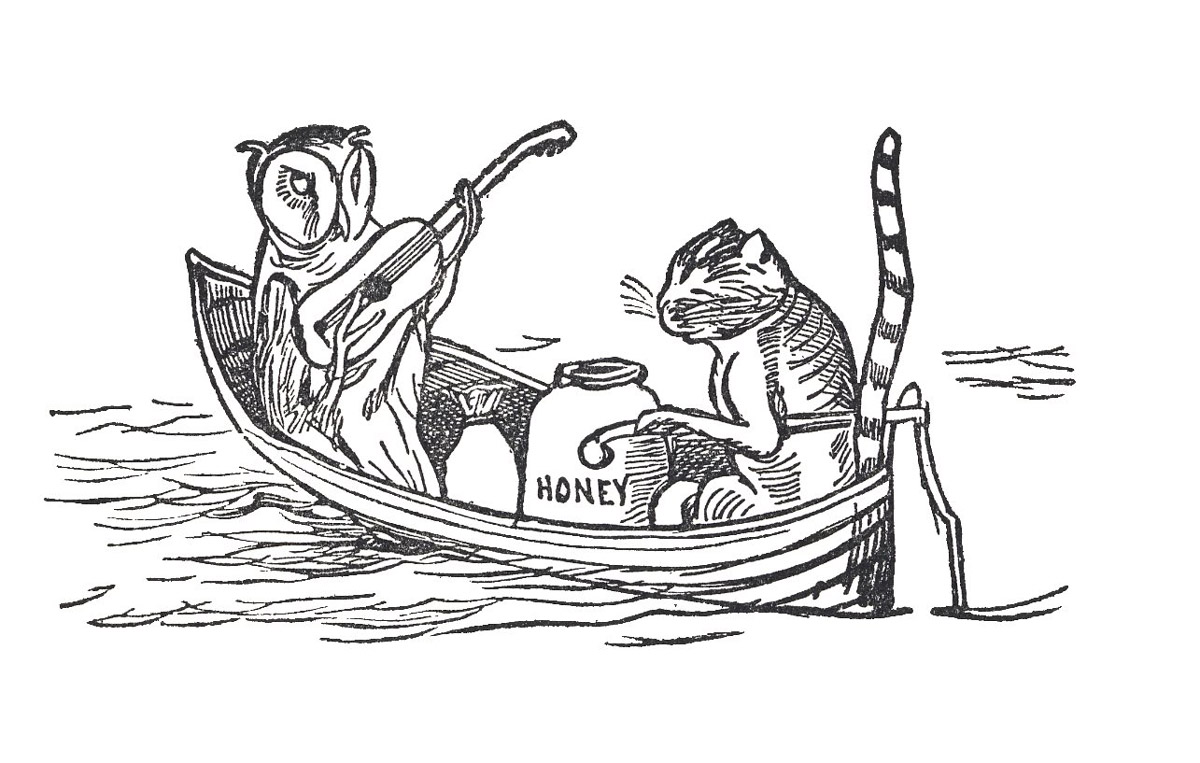